In [29]:
import pandas as pd
import numpy as np
from sklearn import ensemble, preprocessing
import datetime as dt
from sklearn import model_selection
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
%matplotlib inline

In [30]:

# Load dataset 
train = pd.read_csv('asset/train.csv')
test = pd.read_csv('asset/test.csv')
sample = pd.read_csv('asset/sampleSubmission.csv')
weather = pd.read_csv('asset/weather.csv')
spray = pd.read_csv('asset/spray.csv')

# Get labels
labels = train.WnvPresent.values

# Creating dummy variables for the weather data
weather.CodeSum = weather.CodeSum.apply(str.split)
for (i,list_) in enumerate(weather.CodeSum):
    for item in list_:
        if item not in weather.columns:
            weather[item] = 0
        weather.set_value(col=item,index=i,value=1)


# Not using codesum anymore
weather = weather.drop('CodeSum', axis=1)
# Split station 1 and 2 and join horizontally
weather_stn1 = weather[weather['Station']==1]
weather_stn2 = weather[weather['Station']==2]
weather_stn1 = weather_stn1.drop('Station', axis=1)
weather_stn2 = weather_stn2.drop('Station', axis=1)
weather = weather_stn1.merge(weather_stn2, on='Date')

train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)
weather.Date = pd.to_datetime(weather.Date)
spray.Date = pd.to_datetime(spray.Date)

In [31]:
# replace some missing values and T with -1
weather = weather.replace('M', -1)
weather = weather.replace('-', -1)
weather = weather.replace('T', 0)
weather = weather.replace(' T', 0)
weather = weather.replace('  T', 0)

In [32]:
# Functions to extract month and day from dataset
train['year'] = train['Date'].dt.year
train['month'] = train['Date'].dt.month
train['day'] = train['Date'].dt.day
test['year'] = test['Date'].dt.year
test['month'] = test['Date'].dt.month
test['day'] = test['Date'].dt.day

# Add integer latitude/longitude columns
train['Lat_int'] = train.Latitude.apply(int)
train['Long_int'] = train.Longitude.apply(int)
test['Lat_int'] = test.Latitude.apply(int)
test['Long_int'] = test.Longitude.apply(int)

In [25]:
# drop address columns
train = train.drop(['Address', 'AddressNumberAndStreet','WnvPresent', 'NumMosquitos'], axis = 1)
test = test.drop(['Id', 'Address', 'AddressNumberAndStreet'], axis = 1)

In [42]:
days = 7
df = train
def merge_weather_previous_days(df, days, df_weather = weather):
    for i in range(0, days):
        df['Date'+ '_' + str(i)] = df.Date.apply(lambda a: a - pd.Timedelta(days=1))
        df = df.merge(weather, left_on='Date'+ '_' + str(i), right_on='Date')
    return df

In [45]:
weather['Date'

0      2007-05-01
1      2007-05-02
2      2007-05-03
3      2007-05-04
4      2007-05-05
5      2007-05-06
6      2007-05-07
7      2007-05-08
8      2007-05-09
9      2007-05-10
10     2007-05-11
11     2007-05-12
12     2007-05-13
13     2007-05-14
14     2007-05-15
15     2007-05-16
16     2007-05-17
17     2007-05-18
18     2007-05-19
19     2007-05-20
20     2007-05-21
21     2007-05-22
22     2007-05-23
23     2007-05-24
24     2007-05-25
25     2007-05-26
26     2007-05-27
27     2007-05-28
28     2007-05-29
29     2007-05-30
          ...    
1442   2014-10-02
1443   2014-10-03
1444   2014-10-04
1445   2014-10-05
1446   2014-10-06
1447   2014-10-07
1448   2014-10-08
1449   2014-10-09
1450   2014-10-10
1451   2014-10-11
1452   2014-10-12
1453   2014-10-13
1454   2014-10-14
1455   2014-10-15
1456   2014-10-16
1457   2014-10-17
1458   2014-10-18
1459   2014-10-19
1460   2014-10-20
1461   2014-10-21
1462   2014-10-22
1463   2014-10-23
1464   2014-10-24
1465   2014-10-25
1466   201

In [202]:
# Merge with weather data
train = train.merge(weather, on='Date')
test = test.merge(weather, on='Date')

# train = train.merge(spray, on='Date')
# test = test.merge(spray, on='Date')

In [203]:
# This function allows you to create columns for the data_df input that will have a value of 1 or zero
# If a trap has been sprayed with in the time period specified

def create_sprayed_cols(data_df, spray_df, time_period=2):
    # Iterating over unique dates that sprays took place
    # Sprays took place over 10 days as trucks drove around chicago
    for date in set(spray_df.Date):
        # I only want data for this unique date
        spray_temp = spray_df[spray_df.Date == date]
        # Resetting index to make iterating easier
        spray_temp.index = range(0, len(spray_temp))
        
        # I am creating a column for every unique date and initalizing it's rows to 0
        # I will set these values to 1 when I find a trap that was sprayed
        col_name = 'spray_'+date.strftime('%Y-%m-%d')+"_"+str(time_period)
        data_df[col_name] = 0

        # Iterating over each row of our training data to determine if a trap is in the location
        # of a spray. I am also checking to see if the spray was in the past
        for r in range(0,len(data_df)):
            if data_df.get_value(r,'Date') > date and data_df.get_value(r,'Date') < date + pd.Timedelta(weeks=2) :

                # I am casting the lat and long to ints, and multiplaying by 100 to truncate precision
                # In other words, I'm taking pin points and making them into squares
                cur_lat = int(data_df.get_value(r, 'Latitude') * 100)
                cur_long = int(data_df.get_value(r, 'Longitude') * 100)
                
                # Iterating over each value in my spray data
                for i in range(0, len(spray_temp)):

                    spray_lat = int(spray_temp.get_value(i,'Latitude')*100)
                    spray_long = int(spray_temp.get_value(i,'Longitude')*100)

                    # I am now checking if something is in the square +/- some threshold
                    if (cur_lat < spray_lat + 10 and cur_lat > spray_lat - 10) and \
                    (cur_long < spray_long + 10 and cur_long > spray_long - 10):
                        data_df.set_value(r,col_name, 1)
                        break

In [204]:
create_sprayed_cols(train, spray, time_period=1)
create_sprayed_cols(test,spray, time_period=1)

In [205]:
#Convert categorical data to numbers
lbl = preprocessing.LabelEncoder()
lbl.fit(list(train['Species'].values) + list(test['Species'].values))
train['Species'] = lbl.transform(train['Species'].values)
test['Species'] = lbl.transform(test['Species'].values)

lbl.fit(list(train['Street'].values) + list(test['Street'].values))
train['Street'] = lbl.transform(train['Street'].values)
test['Street'] = lbl.transform(test['Street'].values)

lbl.fit(list(train['Trap'].values) + list(test['Trap'].values))
train['Trap'] = lbl.transform(train['Trap'].values)
test['Trap'] = lbl.transform(test['Trap'].values)

train = pd.get_dummies(train, prefix = ['Trap', 'Species'],\
                                      columns=['Trap','Species'],drop_first=True)
test = pd.get_dummies(test, prefix = ['Trap', 'Species'],\
                                     columns=['Trap','Species'], drop_first=True)


In [206]:
# drop columns with -1s
train = train.loc[:,(train != -1).any(axis=0)]
test = test.loc[:,(test != -1).any(axis=0)]

In [207]:
train = train.drop('Date', axis=1)
test = test.drop('Date', axis=1)
train = train.drop(set(train.columns) - set(test.columns), axis=1)
test = test.drop(set(test.columns) - set(train.columns), axis=1)

In [208]:
_ = train.convert_objects(convert_numeric=True)
_ = test.convert_objects(convert_numeric=True)

/home/roland/anaconda3/envs/ga-immersive/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.
/home/roland/anaconda3/envs/ga-immersive/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


# Grid searching below

In [209]:
n_estimators = [500]
criterion = ['entropy']
max_depth = [2,4]
min_samples_split = [2,3]
max_features = ['auto', 'log2',50]
clf = ensemble.RandomForestClassifier()

In [210]:
# Random Forest Classifier 
grid = model_selection.GridSearchCV(estimator=clf, scoring='roc_auc', param_grid=dict(n_estimators=n_estimators, criterion=criterion,
                                                    max_depth=max_depth, max_features=max_features, min_samples_split=min_samples_split))

grid.fit(train,labels)


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 3], 'max_features': ['auto', 'log2', 50], 'criterion': ['entropy'], 'max_depth': [2, 4], 'n_estimators': [500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

### Evaluating results

In [211]:
grid.best_estimator_.fit(train, labels)

# create predictions and submission file
predictions = grid.best_estimator_.predict_proba(test)[:,1]
sample['WnvPresent'] = predictions
sample.to_csv('beat_the_benchmark.csv', index=False)

In [212]:
grid.best_score_

0.67994756998097217

In [213]:
sum(labels)/float(len(labels))

0.052446221206929371

In [214]:
np.mean(model_selection.cross_val_score(grid.best_estimator_, X=train, y=labels, scoring='roc_auc', n_jobs=7))

0.6798777263368736

In [215]:
model = grid.best_estimator_


#### Looking at feature importances

Feature ranking:
Sunrise_x: 0.265186806346
Sunset_x: 0.193351600033
month: 0.11722847794
year: 0.0484943175435
Cool_x: 0.0431316149881
WetBulb_x: 0.0400698214747
Tavg_x: 0.0367405302116
Tavg_y: 0.0274360389997
Cool_y: 0.0209644533191
Tmax_x: 0.0204030797349
AvgSpeed_x: 0.0168533879655
Species_3: 0.0166242651728
DewPoint_x: 0.0149746466855
AvgSpeed_y: 0.012903083593
ResultSpeed_y: 0.0128343219619
Longitude: 0.0127416111554
DewPoint_y: 0.0122690435616
Tmin_y: 0.0118596836764
Tmax_y: 0.011477894901
ResultSpeed_x: 0.00823990598549
Depart_x: 0.00651053579587
Tmin_x: 0.00634832015404
Species_1: 0.00562148110599
WetBulb_y: 0.00560694298425
SeaLevel_y: 0.0052625607786
spray_2013-08-16_1: 0.0036556383354
StnPressure_x: 0.00363852165279
spray_2013-09-05_1: 0.00356989637587
StnPressure_y: 0.00325508730566
Latitude: 0.00284276068781
Heat_y: 0.00199865747457
SeaLevel_x: 0.00133233455896
FG_y: 0.00121390658398
spray_2013-08-08_1: 0.00089538377467
ResultDir_y: 0.000778421497708
Heat_x: 0.000733936353

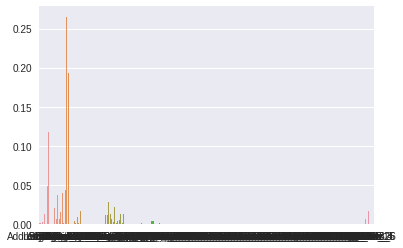

In [216]:
# Zipping feature importances and sorting by how importnat they are
importances = zip(train.columns,model.feature_importances_)
importances.sort(key=lambda x: x[1])
importances = importances[::-1]
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)

# Print the feature ranking
print("Feature ranking:")

for f in range(train.shape[1]):
    print("{}: {}".format(importances[f][0], importances[f][1]))

# Plot the feature importances of the forest
sns.barplot(x=train.columns, y=model.feature_importances_)


In [217]:
grid.best_params_

{'criterion': 'entropy',
 'max_depth': 2,
 'max_features': 50,
 'min_samples_split': 3,
 'n_estimators': 500}